In [30]:
%load_ext autoreload
%autoreload 2

# General
import pynwb
import numpy as np

# Local
from nwb_query import ContinuousData, PointData, EventData, TimeIntervals

# Plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'lines.solid_capstyle': 'butt'})
mdates.rcParams.update({'date.autoformatter.microsecond': '%H:%M:%S.%f'})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Todo
- ContinuousData accessors (based on column names?)
- Make ContinuousData and PointProcess iterable by interval (return single interval and its data)
- Convenience functions: obs_durations (diff of obs_intervals)
- write occupancy function
- query spiking by epoch before doing behavior selection (requires adding epochs to NWBfile)
    - requires extracting epoch information from nspike
- behavior (position/speed) indexed by time, and not by epoch name
    - requires concatenating behav on import
- ? Subclass PointProcess for spiking data (include other columns: clustering metadata, e.g.)
- ? Subclass ContinuousData for Behavioral data (include SI units?)

### Data import and analysis parameters

In [31]:
# what data to analyze
d = {}
d['anim'] = 'Bon'
d['day'] = 4 # 1-indexed

d['epoch'] = 4 # 1-indexed
d['cluster_id'] = 30

# analysis configuration
c = {}
c['speed_threshold'] = 0.05 # m/s

### Read NWB file

In [32]:
animday = '{}{:02d}'.format(d['anim'], d['day'])
nwb_filename = './' + animday + '_test.nwb'

print('Loading file: %s' % nwb_filename)
io = pynwb.NWBHDF5IO(nwb_filename, mode='r')
nwbf = io.read()
 
sst = nwbf.session_start_time.timestamp()

Loading file: ./Bon04_test.nwb


### Dataset Query: speed of a given animal, day, and epoch
#### NWBFile (one animal), day, epoch --> ContinuousProcess (speed)

In [33]:
speed_module_name = 'Speed d{:d} e{:d}'.format(d['day'], d['epoch']) # HACKY--we should query on epoch directly
speed_h5py = nwbf.modules['Behavior']['Speed'][speed_module_name]
speed = ContinuousData(data=speed_h5py.data[()], timestamps=speed_h5py.timestamps[()])

### Dataset Query: position of a given animal, day, and epoch
#### NWBFile (one animal), day, epoch --> ContinuousProcess (position)

In [34]:
position_module_name = 'Position d{:d} e{:d}'.format(d['day'], d['epoch']) # HACKY--we should query on epoch directly
position_h5py = nwbf.modules['Behavior']['Position'][position_module_name]
position = ContinuousData(position_h5py.data[()], position_h5py.timestamps[()])

print('*** All position records for epoch ***')
print('# of measurements = %d' % position.data.shape[0])
print('# of intervals = %d' % len(position.obs_intervals))
print('duration of intervals = %0.2f s' % np.sum(position.obs_intervals.durations()))

*** All position records for epoch ***
# of measurements = 28082
# of intervals = 1
duration of intervals = 936.96 s


### Dataset Query: spiking of a given animal and cluster
#### NWBFile (one animal), cluster --> PointProcess (spiking)

In [35]:
# Get spike times and obs_intervals
spikes_t = nwbf.units['spike_times'][d['cluster_id']]
obs_intervals = TimeIntervals(nwbf.units['obs_intervals'][d['cluster_id']])
spiking = PointData(event_times=spikes_t,
                       obs_intervals=obs_intervals)

print('*** Spiking for cluster %s ***' % d['cluster_id'])
print('# of spikes = %d' % spiking.event_times.shape[0])
print('# of intervals = %d (epochs?)' % len(spiking.obs_intervals))
print('duration of intervals = %0.2f s' % np.sum(spiking.obs_intervals.durations()))

*** Spiking for cluster 30 ***
# of spikes = 2192
# of intervals = 7 (epochs?)
duration of intervals = 7163.00 s


### TODO ----->  Query: Find spiking within an epoch
#### PointProcess (spiking), TimeInterval (epoch) --> PointProcess (spiking)

In [36]:
# epoch_time_interval = TimeIntervals(np.array([[epoch_start, epoch_end]]))
# spiking.time_query(epoch_time_interval)

### Analysis: Find time intervals where speed > threshold
#### ContinuousData (speed), lambda function --> TimeSelection
This is an _analysis_, not a query, because we are not simply selecting a subset of a given datatype. i.e. We are not asking for a subset of the speed data, but rather for the intervals where it fulfills a lambda function. The lambda function could have been something different, like "find the times of all upward threshold crossings, and then pad this by 5 seconds on either side.". Regardless of how simple or complex the lambda function is, we consider this to be an analysis. Using the output of this to select a subset of the spiking data, however, is a query.

In [37]:
speed_threshold_fn = lambda x: x > c['speed_threshold']
speed_time_selection = speed.filter_intervals(speed_threshold_fn)

print('*** Times where speed > threshold ***')
print('# of selection intervals = %d' % len(speed_time_selection.event_intervals))
print('duration of selection intervals = %0.2f s' % np.sum(speed_time_selection.durations()))
print('# of observation intervals = %d' % len(speed_time_selection.obs_intervals))
print('duration of observation intervals = %0.2f s' % np.sum(speed_time_selection.obs_durations()))

*** Times where speed > threshold ***
# of selection intervals = 264
duration of selection intervals = 376.94 s
# of observation intervals = 1
duration of observation intervals = 936.96 s


### Query: spiking during time intervals where speed > threshold
#### PointProcess (spiking), TimeSelection --> PointProcess (spiking)

In [38]:
spiking_run = spiking.time_query(speed_time_selection)  # Use the built-in time query method on PointProcess

print('*** Spiking where speed > threshold ***')
print('# of spikes = %d' % len(spiking_run.event_times))
print('# of intervals = %d' % len(spiking_run.obs_intervals))
print('duration of intervals = %0.2f s' % np.sum(spiking_run.obs_intervals.durations()))
print()

*** Spiking where speed > threshold ***
# of spikes = 312
# of intervals = 264
duration of intervals = 376.94 s



### Analysis: Mark animal position at the event time of each spike
#### PointProcess (spiking), ContinuousData (position[m x 2]) --> PointProcess with marks (spike times with associated positions)

In [39]:
spiking_run_mark_pos = spiking_run.mark_with_ContinuousData(position)

print('*** Spiking where speed > threshold, marked with position ***')
print('# of marked spikes = %d' % len(spiking_run_mark_pos.event_times))
print('# of intervals = %d' % len(spiking_run_mark_pos.obs_intervals))
print('duration of intervals = %0.2f s' % np.sum(spiking_run_mark_pos.obs_intervals.durations()))
print()

*** Spiking where speed > threshold, marked with position ***
# of marked spikes = 312
# of intervals = 264
duration of intervals = 376.94 s



### Query: Get animal locations during running intervals
#### ContinuousData (position [m x 2]), TimeIntervals --> ContinuousData (position [m_new x 2])

In [45]:
position_run = position.time_query(speed_time_selection)

print('*** Position where speed > threshold ***')
print('# of samples = %d' % position_run.data.shape[0])
print('# of intervals = %d' % len(position_run.obs_intervals))
print('duration of intervals = %0.2f s' % np.sum(position_run.obs_intervals.durations()))
print()

*** Position where speed > threshold ***
# of samples = 11561
# of intervals = 264
duration of intervals = 376.94 s



### Plot spikes by location

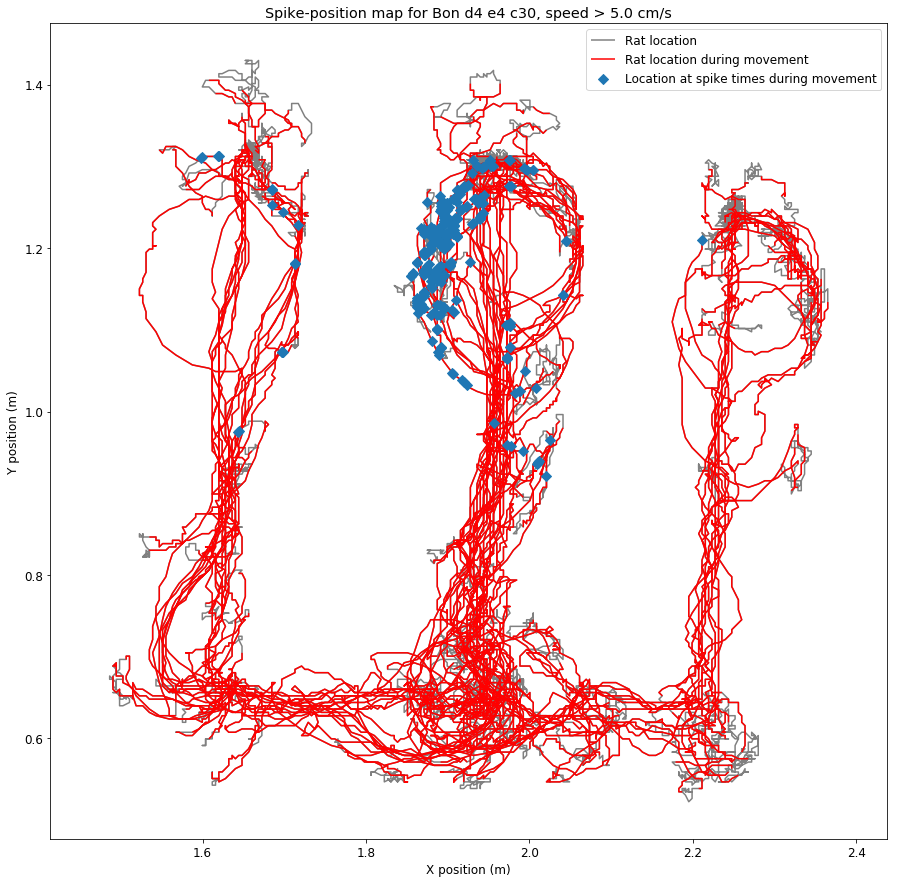

In [46]:
fig1 = plt.figure(1, figsize=(15,15))
ax1 = fig1.add_subplot(1,1,1)
ax1.axis('equal')

# Line showing the animal's movement during the entire epoch
plt.plot(position.data[:,0], position.data[:,1], marker='', color='gray', label='Rat location', zorder=1)

# Lines showing animal movement during each interval where it was running
run_label = 'Rat location during movement'
for ivl in position_run.obs_intervals:
    ivl_data = position.time_query(TimeIntervals(ivl)).data  # x,y position at each timestep 
    plt.plot(ivl_data[:,0], ivl_data[:,1], marker='', color='red', label=run_label, zorder=2)
    run_label = '_' # omit later lines from legend

# Markers for locations where unit spiked during animal running
plt.scatter(spiking_run_mark_pos.marks[:, 0], spiking_run_mark_pos.marks[:, 1], marker='D', s=50, label='Location at spike times during movement', zorder=3)

ax1.legend()
ax1.set_xlabel('X position (m)')
ax1.set_ylabel('Y position (m)')
ax1.set_title('Spike-position map for {} d{} e{} c{}, speed > {:0.1f} cm/s'.format(d['anim'], d['day'], d['epoch'], d['cluster_id'], (c['speed_threshold'] * 100)))
pass